### Autoreload

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [82]:
# Task models
from dlomix.models.chargestate import DominantChargeStatePredictor
from dlomix.models.chargestate import ObservedChargeStatePredictor
# Test models
from dlomix.models.experimental_chargestate import LSTMTest
from dlomix.models.experimental_chargestate import LayerTestChargePredictor
# Constants
from dlomix.constants import ALPHABET_UNMOD
# libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 

### Create dummy data

In [83]:
# read in parquet file
df = pd.read_parquet('../data/TUM_third_pool_meta_data.parquet')

In [84]:
# remove UNIMOD sequences
df = df[~df.modified_sequence.str.contains('UNIMOD')]

In [85]:
# randomly sample 10,000 rows
df = df.sample(10000)

In [86]:
# encode the sequences
df.modified_sequence = df.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

In [87]:
# determine the maximum sequence length in the dummy-dataset
max_len = df.modified_sequence.apply(len).max()
max_len

32

In [88]:
# pad sequences to max length with 0s
df.modified_sequence = df.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

In [89]:
# drop all column exept modified_sequence and precursor_charge
df = df[['modified_sequence', 'precursor_charge']]

In [90]:
# Split into features and labels
X = np.array(df.modified_sequence.to_list())
y = df['precursor_charge'].values

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# x_train = np.array(df.modified_sequence.to_list())

### Create model objects

In [92]:
majority_model = DominantChargeStatePredictor()
majority_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [93]:
observed_model = ObservedChargeStatePredictor()
observed_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [94]:
lstm_model_test = LSTMTest()
lstm_model_test.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [95]:
all_of_it_test_model = LayerTestChargePredictor(seq_length=max_len)
all_of_it_test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train models on dummy data

In [96]:
# regularisation: early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [97]:
# test if training works for majority model
history_1 = majority_model.fit(x_train, y_train,epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
250/250 [==============================] - 1s 1ms/step - loss: 0.9149 - accuracy: 0.5936 - val_loss: 0.6972 - val_accuracy: 0.6695
Epoch 2/100
250/250 [==============================] - 0s 835us/step - loss: 0.6084 - accuracy: 0.7070 - val_loss: 0.5245 - val_accuracy: 0.7390
Epoch 3/100
250/250 [==============================] - 0s 846us/step - loss: 0.4948 - accuracy: 0.7611 - val_loss: 0.4649 - val_accuracy: 0.7815
Epoch 4/100
250/250 [==============================] - 0s 843us/step - loss: 0.4445 - accuracy: 0.7931 - val_loss: 0.4774 - val_accuracy: 0.7915
Epoch 5/100
250/250 [==============================] - 0s 834us/step - loss: 0.4220 - accuracy: 0.8055 - val_loss: 0.4344 - val_accuracy: 0.7880
Epoch 6/100
250/250 [==============================] - 0s 862us/step - loss: 0.4069 - accuracy: 0.8105 - val_loss: 0.4256 - val_accuracy: 0.7910
Epoch 7/100
250/250 [==============================] - 0s 834us/step - loss: 0.3955 - accuracy: 0.8180 - val_loss: 0.4353 - val_accu

In [98]:
# test if training works for observed model
history_2 = observed_model.fit(x_train, y_train,epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 1s 1ms/step - loss: 0.9146 - accuracy: 0.6026 - val_loss: 0.6964 - val_accuracy: 0.6670
Epoch 2/10
250/250 [==============================] - 0s 756us/step - loss: 0.6113 - accuracy: 0.7120 - val_loss: 0.5276 - val_accuracy: 0.7495
Epoch 3/10
250/250 [==============================] - 0s 761us/step - loss: 0.4931 - accuracy: 0.7655 - val_loss: 0.4807 - val_accuracy: 0.7905
Epoch 4/10
250/250 [==============================] - 0s 765us/step - loss: 0.4455 - accuracy: 0.7928 - val_loss: 0.4430 - val_accuracy: 0.8015
Epoch 5/10
250/250 [==============================] - 0s 757us/step - loss: 0.4275 - accuracy: 0.8025 - val_loss: 0.4430 - val_accuracy: 0.7780
Epoch 6/10
250/250 [==============================] - 0s 748us/step - loss: 0.4135 - accuracy: 0.8106 - val_loss: 0.4385 - val_accuracy: 0.7905
Epoch 7/10
250/250 [==============================] - 0s 803us/step - loss: 0.4064 - accuracy: 0.8115 - val_loss: 0.4703 - val_accuracy: 0

In [99]:
# Adjusting precursor charge -- HACK --
df['adjusted_precursor_charge'] = df.precursor_charge - 1

In [100]:
history_3 = lstm_model_test.fit(x_train, y_train,epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 5s 9ms/step - loss: 0.7314 - accuracy: 0.6520 - val_loss: 0.4913 - val_accuracy: 0.7690
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4848 - accuracy: 0.7594 - val_loss: 0.4524 - val_accuracy: 0.7695
Epoch 3/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4544 - accuracy: 0.7689 - val_loss: 0.4456 - val_accuracy: 0.7945
Epoch 4/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4366 - accuracy: 0.7841 - val_loss: 0.4277 - val_accuracy: 0.7955
Epoch 5/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4392 - accuracy: 0.7809 - val_loss: 0.4882 - val_accuracy: 0.7805
Epoch 6/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4233 - accuracy: 0.7919 - val_loss: 0.4308 - val_accuracy: 0.7880
Epoch 7/10
250/250 [==============================] - 2s 8ms/step - loss: 0.4207 - accuracy: 0.7928 - val_loss: 0.4317 - val_accuracy: 0.7940
Epoch 

In [101]:
# WIP - not working
# history_4 = all_of_it_test_model.fit(x_train, y_train,epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

### Reporting

In [102]:
def plot_learning_curves(history, title='Learning Curves'):
    """Plot the learning curves for training and validation loss and accuracy. 
    Args:
    - history: Return value from model.fit().
    - title (optional): Base title for the plots. It will be appended with "Loss" and "Accuracy" for the respective plots.
    """
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Dynamically find accuracy keys in history_dict
    accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and not key.startswith('val_')), None)
    val_accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and key.startswith('val_')), None)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot training and validation loss
    ax1.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy if keys exist
    if accuracy_key and val_accuracy_key:
        accuracy = history_dict[accuracy_key]
        val_accuracy = history_dict[val_accuracy_key]
        ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
        ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        ax2.set_title(f'{title} - Accuracy Not Available')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.text(0.5, 0.5, 'Accuracy data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

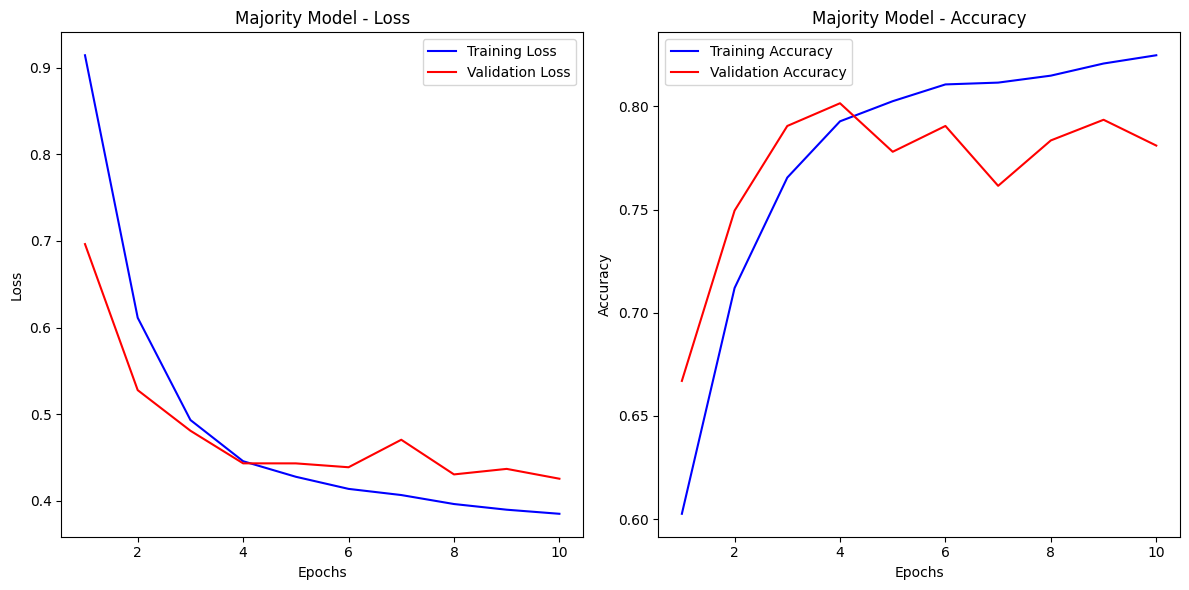

In [103]:
plot_learning_curves(history_2, title='Majority Model')